In [1]:
from mpi4py import MPI
from petsc4py import PETSc

# plotting
import matplotlib.pyplot as plt
import pyvista

# dolfinx and meshing
import numpy as np
from dolfinx import geometry
from dolfinx.fem import Constant, Function, functionspace, assemble_scalar, dirichletbc, form, locate_dofs_geometrical, locate_dofs_topological
from dolfinx.fem.petsc import assemble_matrix, assemble_vector, apply_lifting, create_vector, set_bc
# from dolfinx.io import VTXWriter, gmshio, XDMFFile
from dolfinx.mesh import create_unit_square,create_rectangle, CellType, meshtags, locate_entities_boundary
from dolfinx.plot import vtk_mesh
from basix.ufl import element
from ufl import (FacetNormal, Identity, TestFunction, TrialFunction,Measure,
                 div, dot, ds, dx, inner, lhs, nabla_grad, rhs, sym,
                 SpatialCoordinate, conditional, ge, le)

from dx_utils import create_obst, write_x_parview, store_array, init_db, write_values_to_json
import time

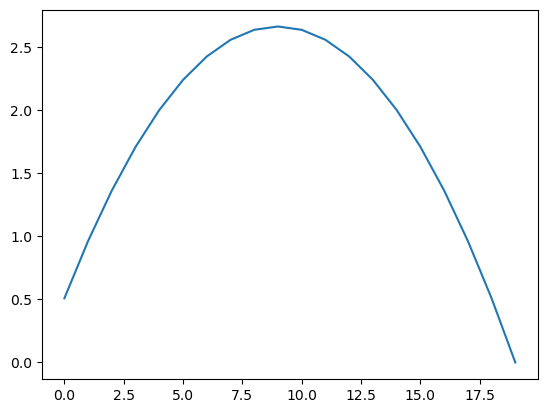

In [26]:
r = np.array([[ 5.09282977e-01, -3.77108318e-06],
 [ 9.63780752e-01, 4.61584707e-06],
 [ 1.36383087e+00 , 2.78184419e-06],
 [ 1.70971141e+00 ,-8.56501596e-07],
 [ 2.00181859e+00,  1.20423108e-06],
 [ 2.24041039e+00 , 1.14520581e-05],
 [ 2.42571973e+00 , 4.10777441e-06],
 [ 2.55793235e+00 , 1.46988817e-05],
 [ 2.63719919e+00 , 1.22304861e-05],
 [ 2.66361523e+00 , 7.27810766e-06],
 [ 2.63720224e+00 , 1.69891389e-06],
 [ 2.55794563e+00, -2.43228787e-06],
 [ 2.42571865e+00, 1.95850177e-06],
 [ 2.24041795e+00 , 1.55534769e-05],
 [ 2.00183822e+00 , 1.06793301e-05],
 [ 1.70973108e+00 , 6.78900551e-06],
 [ 1.36382043e+00, -1.54325017e-06],
 [ 9.63783972e-01, -7.26501102e-06],
 [ 5.09277269e-01 ,-7.83738629e-06],
 [ 1.62250208e-06 , 3.35085444e-08]])
plt.plot(r[:,0])

In [4]:

def mfl_press(x_max, mesh, u_n, p):
    # Extract the normal component of velocity (u_x in 2D)
    u_sub = u_n.sub(0)

    # Define measures and spatial coordinates
    dx = Measure("dx", domain=mesh)
    x = SpatialCoordinate(mesh)
    pos = np.linspace(0+.5,x_max-.5,30)
    mass_flow, pressure_avg = np.array([]), np.array([])
    for i in pos:
        slice_condition = conditional(ge(x[0], i-2e-1), 1.0, 0.0) * conditional(le(x[0], i+2e-1), 1.0, 0.0)
        # Calculate mass flow rate at the current slice
        mf = assemble_scalar(form(u_sub * slice_condition * dx))
        # mf2 = MPI.COMM_WORLD.gather(mf, )
        print(mf)
        mass_flow = np.append(mass_flow,mf)
        # Calculate average pressure at the current slice
        pa = assemble_scalar(form(p * slice_condition * dx)) / assemble_scalar(form(slice_condition * dx) )
        pressure_avg = np.append(pressure_avg, pa)
    return mass_flow, pressure_avg


def plot_para_velo(ax, mesh, u_n, p_n, t, length, pres, Ox, r, tol):
    if MPI.COMM_WORLD.rank == 0:
        y = np.linspace(0+tol, length, int(length/tol))
        points = np.zeros((3, int(length/tol)))
        points[1] = y
        points[0] = 0
        
        bb_tree = geometry.bb_tree(mesh, mesh.topology.dim)
        cells, cells1, cells2, p_o_p, p_o_p1, p_o_p2 = [], [], [], [], [], []

        def get_points_of_cells(bb_tree, msh, point, pop, cell):
            # Find cells whose bounding-box collide with the the points
            cell_candidates = geometry.compute_collisions_points(bb_tree, point.T)
            # Choose one of the cells that contains the point
            colliding_cells = geometry.compute_colliding_cells(msh, cell_candidates, point.T)
            for i, point in enumerate(points.T):
                if len(colliding_cells.links(i)) > 0:
                    pop.append(point)
                    cell.append(colliding_cells.links(i)[0])
            pop = np.array(pop, dtype=np.float64)
            u_val = u_n.eval(pop, cell)
            p_val = p_n.eval(pop, cell)
            return pop, u_val, p_val

        # get velocity procile values at x[0] = 0
        p_o_p, u_values, p_values = get_points_of_cells(bb_tree, mesh, points, p_o_p, cells)

        # get velocity procile values at x of obstacle
        y2 = np.linspace(0+tol, length-(r+tol), int(length/tol))
        points[1] = y2
        points[0] = Ox
        p_o_p1, u_values1, p_values1 = get_points_of_cells(bb_tree, mesh, points, p_o_p1, cells1)

        # get velocity profile at end of canal
        points[1] = y
        points[0] = length
        p_o_p2, u_values2, p_values2 = get_points_of_cells(bb_tree, mesh, points, p_o_p2, cells2)
        
        ax.set_title("Velocity over x-Axis")
        ax.plot(p_o_p[:, 1], u_values[:,0], "k", linewidth=2, label="x=0")
        ax.plot(p_o_p1[:, 1], u_values1[:,0], "y", linewidth=2, label=r"x=%s"%(Ox))
        ax.plot(p_o_p2[:, 1], u_values2[:,0], "b", linewidth=2, label=r"x=%s"%(length))
        ax.legend()
        ax.set_xlabel("x")
        ax.set_ylabel("Velocity u")
        # If run in parallel as a python file, we save a plot per processor
        plt.savefig(f"para_plot/u_n_p_{int(r):d}_{int(pres):d}_{int(t*100):d}.pdf") #25_{int(pres):d}_{int(t*100):d}.pdf")
        return p_o_p[:, 1], u_values[:,0], p_o_p1[:, 1], u_values1[:,0], p_o_p2[:, 1], u_values2[:,0]

def plot_2dmesh(V, mesh, u_n, c):
    topology, cell_types, geo = vtk_mesh(V)
    values = np.zeros((geo.shape[0], 3), dtype=np.float64)
    values[:, :len(u_n)] = u_n.x.array.real.reshape((geo.shape[0], len(u_n)))
    
    # Create a point cloud of glyphs
    function_grid = pyvista.UnstructuredGrid(topology, cell_types, geo)
    function_grid["u"] = values
    glyphs = function_grid.glyph(orient="u", factor=0.2)
    
    # Create a pyvista-grid for the mesh
    grid = pyvista.UnstructuredGrid(*vtk_mesh(mesh, mesh.topology.dim))
    
    # Create plotter
    plotter = pyvista.Plotter()
    plotter.add_mesh(grid, style="wireframe", color="k")
    plotter.add_mesh(glyphs)
    plotter.view_xy()
    if not pyvista.OFF_SCREEN:
        plotter.show()
        plotter.screenshot(f"canal_{c:d}.png")
    else:
        #f"para_plot/u_n_p_canal_test")#{int(pres):d}
        fig_as_array = plotter.screenshot(f"glyphs_{c:d}.png")


In [11]:
def run_sim(height=1, length=3,pres=8,T=.5,num_steps=500,r=0, file=False, run=1, tol=.07):
    Ox = length/2
    if run==0:
        mesh = create_rectangle(MPI.COMM_WORLD,[[0,0], [length, height]],[int(length*25),int(height*25)])
    if run == 1:
        mesh = create_unit_square(MPI.COMM_WORLD, 100, 100)
    if run == 2:
        # create_obst(comm,H=1, L=3,r=.3, Ox=1.5, lc=.07):
        mesh, ct, ft, inlet_marker,outlet_marker, upper_wall_marker, lower_wall_marker = create_obst(MPI.COMM_WORLD,height, length, r, Ox, tol)
    
    debug = False
    t = 0
    pres = pres * length
    dt = T / num_steps

    v_cg2 = element("Lagrange", mesh.topology.cell_name(), 2, shape=(mesh.geometry.dim, ))
    s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
    V = functionspace(mesh, v_cg2)
    Q = functionspace(mesh, s_cg1)
    
    u = TrialFunction(V)
    v = TestFunction(V)
    p = TrialFunction(Q)
    q = TestFunction(Q)

    fdim = mesh.topology.dim - 1

    #write_x_parview(mesh,ct,ft, "my_mesh")

    wall_dofs = locate_dofs_topological(V, fdim, ft.find(upper_wall_marker))
    u_noslip = np.array((0,) * mesh.geometry.dim, dtype=PETSc.ScalarType)
    bc_noslip1 = dirichletbc(u_noslip, wall_dofs, V)

    wall_dofs = locate_dofs_topological(V, fdim, ft.find(lower_wall_marker))
    u_noslip = np.array((0,) * mesh.geometry.dim, dtype=PETSc.ScalarType)
    bc_noslip2 = dirichletbc(u_noslip, wall_dofs, V)
    
    inflow_dofs = locate_dofs_topological(Q, fdim, ft.find(inlet_marker))
    bc_inflow = dirichletbc(PETSc.ScalarType(pres), inflow_dofs, Q)
    
    outflow_dofs = locate_dofs_topological(Q, fdim, ft.find(outlet_marker))
    bc_outflow = dirichletbc(PETSc.ScalarType(0), outflow_dofs, Q)
    bcu = [bc_noslip1, bc_noslip2]
    bcp = [bc_inflow, bc_outflow]
    if debug:
        print("<< done boundary conditions >>")
    
    u_n = Function(V)
    u_n.name = "u_n"
    U = 0.5 * (u_n + u)
    n = FacetNormal(mesh)
    f = Constant(mesh, PETSc.ScalarType((0, 0)))
    k = Constant(mesh, PETSc.ScalarType(dt))
    mu = Constant(mesh, PETSc.ScalarType(1))
    rho = Constant(mesh, PETSc.ScalarType(1))
    
    # Define strain-rate tensor
    def epsilon(u):
        return sym(nabla_grad(u))
    
    # Define stress tensor
    def sigma(u, p):
        return 2 * mu * epsilon(u) - p * Identity(len(u))
    
    
    # Define the variational problem for the first step
    p_n = Function(Q)
    p_n.name = "p_n"
    F1 = rho * dot((u - u_n) / k, v) * dx
    F1 += rho * dot(dot(u_n, nabla_grad(u_n)), v) * dx
    F1 += inner(sigma(U, p_n), epsilon(v)) * dx
    F1 += dot(p_n * n, v) * ds - dot(mu * nabla_grad(U) * n, v) * ds
    F1 -= dot(f, v) * dx
    a1 = form(lhs(F1))
    L1 = form(rhs(F1))
    
    
    A1 = assemble_matrix(a1, bcs=bcu)
    A1.assemble()
    b1 = create_vector(L1)
    
    # Define variational problem for step 2
    u_ = Function(V)
    a2 = form(dot(nabla_grad(p), nabla_grad(q)) * dx)
    L2 = form(dot(nabla_grad(p_n), nabla_grad(q)) * dx - (rho / k) * div(u_) * q * dx)
    A2 = assemble_matrix(a2, bcs=bcp)
    A2.assemble()
    b2 = create_vector(L2)
    
    # Define variational problem for step 3
    p_ = Function(Q)
    a3 = form(rho * dot(u, v) * dx)
    L3 = form(rho * dot(u_, v) * dx - k * dot(nabla_grad(p_ - p_n), v) * dx)
    A3 = assemble_matrix(a3)
    A3.assemble()
    b3 = create_vector(L3)
    
    # Solver for step 1
    solver1 = PETSc.KSP().create(mesh.comm)
    solver1.setOperators(A1)
    solver1.setType(PETSc.KSP.Type.BCGS)
    pc1 = solver1.getPC()
    pc1.setType(PETSc.PC.Type.HYPRE)
    pc1.setHYPREType("boomeramg")
    
    # Solver for step 2
    solver2 = PETSc.KSP().create(mesh.comm)
    solver2.setOperators(A2)
    solver2.setType(PETSc.KSP.Type.BCGS)
    pc2 = solver2.getPC()
    pc2.setType(PETSc.PC.Type.HYPRE)
    pc2.setHYPREType("boomeramg")
    
    # Solver for step 3
    solver3 = PETSc.KSP().create(mesh.comm)
    solver3.setOperators(A3)
    solver3.setType(PETSc.KSP.Type.CG)
    pc3 = solver3.getPC()
    pc3.setType(PETSc.PC.Type.SOR)
    if debug:
        print("<< formulated function and solvers >>")
    if file:
        from pathlib import Path
        folder = Path("results")
        folder.mkdir(exist_ok=True, parents=True)
        vtx_u = VTXWriter(mesh.comm, folder / "poiseuille_u.bp", u_n, engine="BP4")
        vtx_p = VTXWriter(mesh.comm, folder / "poiseuille_p.bp", p_n, engine="BP4")
        vtx_u.write(t)
        vtx_p.write(t)
    
    def u_exact(x):
        values = np.zeros((2, x.shape[1]), dtype=PETSc.ScalarType)
        values[0] = 4 * x[1] * (1.0 - x[1])
        return values
    
    u_ex = Function(V)
    u_ex.interpolate(u_exact)
    
    L2_error = form(dot(u_ - u_ex, u_ - u_ex) * dx)

    # add a simple plot output 
    
    if debug:
        print("<< starting loop >>")
    for i in range(num_steps):
        # Update current time step
        t += dt
        
        # Step 1: Tentative veolcity step
        with b1.localForm() as loc_1:
            loc_1.set(0)
        assemble_vector(b1, L1)
        apply_lifting(b1, [a1], [bcu])
        b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        set_bc(b1, bcu)
        solver1.solve(b1, u_.x.petsc_vec)
        u_.x.scatter_forward()
    
        # Step 2: Pressure corrrection step
        with b2.localForm() as loc_2:
            loc_2.set(0)
        assemble_vector(b2, L2)
        apply_lifting(b2, [a2], [bcp])
        b2.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        set_bc(b2, bcp)
        solver2.solve(b2, p_.x.petsc_vec)
        p_.x.scatter_forward()
    
        # Step 3: Velocity correction step
        with b3.localForm() as loc_3:
            loc_3.set(0)
        assemble_vector(b3, L3)
        b3.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        solver3.solve(b3, u_.x.petsc_vec)
        u_.x.scatter_forward()
        # Update variable with solution form this time step
        u_n.x.array[:] = u_.x.array[:]
        p_n.x.array[:] = p_.x.array[:]
    
        # print velocity profile"""(i!=0) and (i % int(num_steps/5) == 0) or"""
        #if (i == num_steps - 1) and MPI.COMM_WORLD.rank == 0:
        # u_gathered = MPI.COMM_WORLD.gather(u_, root=0)
        # p_gathered = MPI.COMM_WORLD.gather(p_, root=0)
        #f"Hello World from rank {MPI.COMM_WORLD.Get_rank()}. total ranks={MPI.COMM_WORLD.Get_size()}"

        #if file:
        #    # Write solutions to fileV
        #    vtx_u.write(t)
        #    vtx_p.write(t)
    
        # Compute error at current time-step
        error_L2 = np.sqrt(mesh.comm.allreduce(assemble_scalar(L2_error), op=MPI.SUM))
        error_max = mesh.comm.allreduce(np.max(u_.x.petsc_vec.array - u_ex.x.petsc_vec.array), op=MPI.MAX)
        # Print error only every 20th step and at the last step
        if (i % 20 == 0) or (i == num_steps - 1):
            print(f"Time {t:.2f}, L2-error {error_L2:.2e}, Max error {error_max:.2e}")
    # Close xmdf file
    #if file:
    #    vtx_u.close()
    #    vtx_p.close()
    b1.destroy()
    b2.destroy()
    b3.destroy()
    solver1.destroy()
    solver2.destroy()
    solver3.destroy()
    return u_n, p_n, V, mesh

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 8 (Line)
Info    : [ 20%] Meshing curve 9 (Line)
Info    : [ 40%] Meshing curve 10 (Line)
Info    : [ 60%] Meshing curve 11 (Line)
Info    : [ 70%] Meshing curve 12 (Line)
Info    : [ 90%] Meshing curve 13 (Circle)
Info    : Done meshing 1D (Wall 0.000575778s, CPU 0.000478s)
Info    : Meshing 2D...
Info    : Meshing surface 16 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.261725s, CPU 0.263371s)
Info    : 13320 nodes 26643 elements
<< meshing in gmshio >> 
 comm_rank is: 0
<< returning mesh >>
Time 0.00, L2-error 2.30e+00, Max error 1.54e-03
Time 0.00, L2-error 2.23e+00, Max error 1.69e-02
Time 0.01, L2-error 2.16e+00, Max error 2.92e-02
Time 0.01, L2-error 2.10e+00, Max error 4.00e-02
Time 0.01, L2-error 2.03e+00, Max error 4.97e-02
Time 0.02, L2-error 1.97e+00, Max error 5.87e-02
Time 0.02, L2-error 1.91e+00, Max error 6.71e-02
Time 0.02, L2-error 1.86e+00, Max error 7.50e-02
Time 0.03, L2-error 1.80e+00, Max error 

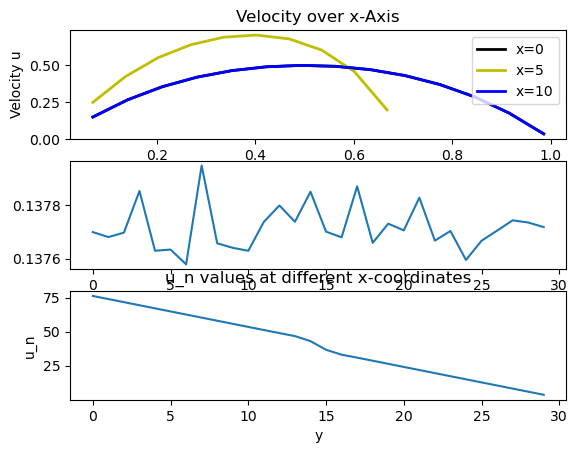

'store_array(mfl, "massflowrate", pat,p)\nstore_array(pa, "pressure_avg", pat,p)           \nstore_array(x1, "x_at_0", pat,p)\nstore_array(y1, "y_at_0", pat,p)\nstore_array(x2, "x_at_.5", pat,p)\nstore_array(y2, "y_at_.5", pat,p)\nstore_array(x3, "x_at_1", pat,p)\nstore_array(y3, "y_at_1", pat,p)\np.freeze()'

In [13]:
#for i in np.linspace(0.05,0.5,19):
fig, ax = plt.subplots(3,1)
plt.xlabel('y')
plt.ylabel('u_n')
plt.title('u_n values at different x-coordinates')

#if MPI.COMM_WORLD.rank == 0:
# p, pat = init_db(f"canal_{i:.2f}_3", False)
#p, pat = init_db(f"{time.time():.2f}",False)
height, length, pres, T, num_steps, r, Ox, tol = 1,10,20,3,500,.5 ,5,.07
# annotate metadata : height=1, length=3,pres=8,T=.5,num_steps=500,r=0, file=False, run=1, tol=.07):
#p.put_annotation("metadata", write_values_to_json([height, length, pres, T, num_steps, r, Ox, tol],
#                                                  ["height", "length", "pressure_delta", "simulation_time", 
#                                                   "steps", "radius", "obstacle_location_x","meshing_size/tol"]))
u_, p_, V, mesh = run_sim(height=1,length=10,pres=8,T=.08,num_steps=500,r=.3,file=False,run=2, tol=0.03)

#if MPI.COMM_WORLD.rank == 0:
mfl, pa = mfl_press(length, mesh, u_, p_) # comm.bcast(lower, root=0)
x1, y1, x2, y2, x3, y3 = plot_para_velo(ax[0],mesh, u_, p_, T, length, pres,Ox, r, tol)
ax[1].plot(mfl)
ax[2].plot(pa)
plt.show()
"""store_array(mfl, "massflowrate", pat,p)
store_array(pa, "pressure_avg", pat,p)           
store_array(x1, "x_at_0", pat,p)
store_array(y1, "y_at_0", pat,p)
store_array(x2, "x_at_.5", pat,p)
store_array(y2, "y_at_.5", pat,p)
store_array(x3, "x_at_1", pat,p)
store_array(y3, "y_at_1", pat,p)
p.freeze()"""

In [ ]:
import ipyparallel as ipp
def mpi_example():
    comm = MPI.COMM_WORLD
    return f"Hello World from rank {comm.Get_rank()}. total ranks={comm.Get_size()}"

with ipp.Cluster(engines='mpi', n=4) as rc:
    # get a broadcast_view on the cluster which is best
    # suited for MPI style computation
    view = rc.broadcast_view()
    # run the mpi_example function on all engines in parallel
    r = view.apply_sync(mpi_example)
    # Retrieve and print t


In [21]:
array = np.array([1,2,3,4])
arr = np.array([0,0,0,0])
ar1 = np.concat((arr, array,arr, arr))
ar2 = np.concat((array,arr, arr, arr))
ar3 = np.concat((arr, arr,array, arr))

def combine_nonzero_preserve_order(*arrays):
    stacked = np.hstack(arrays)  # Use hstack instead of vstack
    nonzero_values = stacked[stacked != 0]
    return nonzero_values

result = combine_nonzero_preserve_order(ar1, ar2, ar3, arr)
print(result)

[1 2 3 4 1 2 3 4 1 2 3 4]


In [19]:
ar1

array([0, 0, 0, 0, 1, 2, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0])